In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import torch.nn as nn
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights

class Food101Dataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.classes = sorted(os.listdir(data_folder))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls_name in self.classes:
            cls_path = os.path.join(self.data_folder, cls_name)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                images.append((img_path, self.class_to_idx[cls_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformation for the images
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to your data folder
data_folder = "C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/Facultate/IAVA/Proiect/Food Classifier Final/cross_validation/google images"

# Create dataset
food101_dataset = Food101Dataset(data_folder, transform=transform)

# Create dataloader
batch_size = 32
data_loader = DataLoader(food101_dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

def test_acc(net: nn.Module, test_loader: DataLoader):

  net.to(device)
  net.eval()
  
  total = 0
  correct = 0
  top2_correct = 0

  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    total += labels.size(0)

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()

    _, predicted2 = torch.topk(outputs, 2, dim=1)  # Get top 2 predictions
    top2_correct += ((predicted2 == labels.view(-1, 1)) | (predicted2[:, 1].view(-1, 1) == labels.view(-1, 1))).sum().item()

  return (correct / total * 100, top2_correct / total * 100)

cuda
NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        resnet = nn.Sequential(*list(resnet.children())[:-1])
        for param in resnet.parameters():
            param.requires_grad = False

        self.model = nn.Sequential(
            resnet,
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 101)
        )

    def forward(self, x):
        return self.model(x)

In [3]:
model = Model()

start = time.time()
for i in range(1, 13):

    state_dict = torch.load(f'model_epoch{i}.pkl')
    model.load_state_dict(state_dict)

    accuracy, top2accuracy = test_acc(model, data_loader)

    print(f'Epoch {i}: accuracy - {accuracy:.3f}%, top 2 accuracy - {top2accuracy:.3f}%')

print(f'Testing duration: {time.time() - start}')

Epoch 1: accuracy - 52.326%, top 2 accuracy - 79.068%
Epoch 2: accuracy - 53.484%, top 2 accuracy - 80.246%
Epoch 3: accuracy - 57.340%, top 2 accuracy - 83.337%
Epoch 4: accuracy - 57.330%, top 2 accuracy - 83.709%
Epoch 5: accuracy - 56.977%, top 2 accuracy - 82.612%
Epoch 6: accuracy - 58.890%, top 2 accuracy - 84.344%
Epoch 7: accuracy - 59.182%, top 2 accuracy - 84.998%
Epoch 8: accuracy - 58.800%, top 2 accuracy - 85.723%
Epoch 9: accuracy - 58.639%, top 2 accuracy - 84.776%
Epoch 10: accuracy - 59.505%, top 2 accuracy - 84.454%
Epoch 11: accuracy - 57.984%, top 2 accuracy - 83.780%
Epoch 12: accuracy - 58.840%, top 2 accuracy - 84.636%
Testing duration: 4536.252624750137


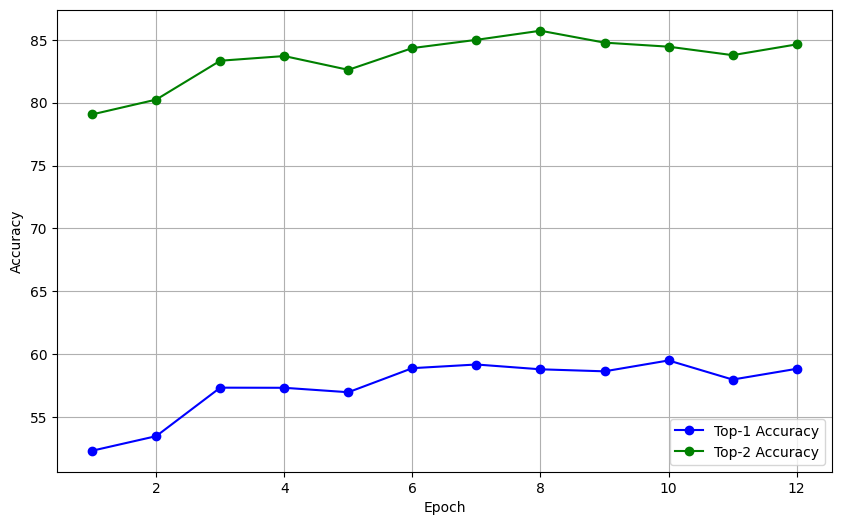

In [3]:
import matplotlib.pyplot as plt

# Data for top-1 accuracy and top-2 accuracy
epochs = list(range(1, 13))
top1_accuracy = [52.326, 53.484, 57.340, 57.330, 56.977, 58.890, 59.182, 58.800, 58.639, 59.505, 57.984, 58.840]
top2_accuracy = [79.068, 80.246, 83.337, 83.709, 82.612, 84.344, 84.998, 85.723, 84.776, 84.454, 83.780, 84.636]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(epochs, top1_accuracy, label='Top-1 Accuracy', color='blue', marker='o')
plt.plot(epochs, top2_accuracy, label='Top-2 Accuracy', color='green', marker='o')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()